# Experiment 15 PatchTST

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 111.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
!unzip train.csv.zip
!unzip features.csv.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 913MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  features.csv.zip
  inflating: features.csv            


In [3]:
!pip install torch mlflow dagshub scikit-learn pandas numpy matplotlib seaborn joblib -q wandb torch torchvision torchaudio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import math

# Core libraries
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning libraries
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F
    TORCH_AVAILABLE = True
    print("✅ PyTorch is available")
    print(f"   🔥 PyTorch version: {torch.__version__}")
    print(f"   🧠 CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    TORCH_AVAILABLE = False
    print("❌ PyTorch not available. Please install with:")
    print("   pip install torch torchvision torchaudio")
    print(f"   Import error: {e}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


✅ PyTorch is available
   🔥 PyTorch version: 2.6.0+cu124
   🧠 CUDA available: True


In [5]:
class WalmartPreprocessingPipeline:
    """
    Preprocessing pipeline for Walmart sales data
    Same as used in TimesFM, N-BEATS, and DLinear experiments
    """

    def __init__(self):
        self.fitted = False
        self.outlier_thresholds = None
        self.train_data_for_lags = None

    def load_and_prepare_data(self):
        """Load and prepare raw data"""
        print("📂 Loading Walmart sales data...")

        try:
            # Load main datasets (from current directory, not data/ subdirectory)
            train = pd.read_csv('train.csv')
            stores = pd.read_csv('stores.csv')
            features = pd.read_csv('features.csv')

            print(f"   📊 Train data: {train.shape}")
            print(f"   🏪 Stores data: {stores.shape}")
            print(f"   🎯 Features data: {features.shape}")

            # Parse dates
            train['Date'] = pd.to_datetime(train['Date'])
            features['Date'] = pd.to_datetime(features['Date'])

            # Merge datasets
            train_merged = train.merge(stores, on='Store', how='left')
            train_full = train_merged.merge(features, on=['Store', 'Date'], how='left')

            print(f"   ✅ Merged data: {train_full.shape}")
            return train_full

        except FileNotFoundError as e:
            print(f"❌ Error loading data: {e}")
            print("Please ensure data files are in the current directory")
            raise

    def clean_merged_data(self, train_full):
        """Clean the merged dataset"""
        print("🧹 Cleaning merged data...")

        initial_len = len(train_full)

        # Handle duplicate IsHoliday columns if they exist
        if 'IsHoliday_x' in train_full.columns and 'IsHoliday_y' in train_full.columns:
            print("   🔄 Resolving duplicate IsHoliday columns...")
            train_full['IsHoliday'] = train_full['IsHoliday_x'] | train_full['IsHoliday_y']
            train_full = train_full.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)

        # Remove rows with missing Store or Dept
        train_full = train_full.dropna(subset=['Store', 'Dept'])

        # Fill missing values
        numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        for col in numeric_cols:
            if col in train_full.columns:
                train_full[col] = train_full[col].fillna(train_full[col].median())

        # Fill missing MarkDown columns with 0
        markdown_cols = [col for col in train_full.columns if 'MarkDown' in col]
        for col in markdown_cols:
            train_full[col] = train_full[col].fillna(0)

        final_len = len(train_full)
        print(f"   📊 Cleaned: {initial_len:,} → {final_len:,} rows")

        return train_full

    def create_temporal_split(self, df, train_ratio=0.8):
        """Create temporal train/validation split"""
        print("📅 Creating temporal split...")

        df_sorted = df.sort_values('Date')

        # Find split date
        unique_dates = df_sorted['Date'].unique()
        split_idx = int(len(unique_dates) * train_ratio)
        split_date = unique_dates[split_idx]

        # Split data
        train_data = df_sorted[df_sorted['Date'] < split_date].copy()
        val_data = df_sorted[df_sorted['Date'] >= split_date].copy()

        split_info = {
            'split_date': split_date,
            'train_date_range': (train_data['Date'].min(), train_data['Date'].max()),
            'val_date_range': (val_data['Date'].min(), val_data['Date'].max()),
            'train_weeks': len(train_data['Date'].unique()),
            'val_weeks': len(val_data['Date'].unique())
        }

        print(f"   📊 Train: {len(train_data):,} samples ({split_info['train_weeks']} weeks)")
        print(f"   📊 Validation: {len(val_data):,} samples ({split_info['val_weeks']} weeks)")
        print(f"   📅 Split date: {split_date}")

        return train_data, val_data, split_info

    def fit(self, train_data):
        """Fit the preprocessing pipeline on training data"""
        print("🔧 Fitting preprocessing pipeline on training data...")

        # Store training data for lag feature creation
        self.train_data_for_lags = train_data.copy()

        # Fit outlier removal thresholds on training data only
        self.outlier_thresholds = {
            'A': {'lower': -1000, 'upper': 50000},  # Type A stores
            'B': {'lower': -500, 'upper': 25000},   # Type B stores
            'C': {'lower': -200, 'upper': 15000}    # Type C stores
        }

        print("✅ Pipeline fitted on training data")
        self.fitted = True
        return self

    def transform(self, data, is_validation=False):
        """Transform data using fitted pipeline"""
        if not self.fitted:
            raise ValueError("Pipeline must be fitted before transform!")

        print(f"🔄 Transforming {'validation' if is_validation else 'training'} data...")

        df = data.copy()

        # Step 1: Create date features
        df = self._create_date_features(df)

        # Step 2: Create holiday features
        df = self._create_holiday_features(df)

        # Step 3: Encode categorical features (BEFORE outlier removal!)
        df = self._encode_categorical_features(df)

        # Step 4: Remove outliers (only on training data, AFTER encoding)
        if not is_validation:
            df = self._remove_outliers(df)

        # Step 5: Remove markdown features
        df = self._remove_markdown_features(df)

        # Step 6: Remove redundant features
        df = self._remove_redundant_features(df)

        print(f"✅ Transform complete. Shape: {df.shape}")
        return df

    def fit_transform(self, train_data):
        """Fit and transform training data in one step"""
        return self.fit(train_data).transform(train_data, is_validation=False)

    def _create_date_features(self, df):
        """Create date features"""
        df = df.copy()
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
        df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
        df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
        df['IsQuarterStart'] = df['Date'].dt.is_quarter_start.astype(int)
        df['IsQuarterEnd'] = df['Date'].dt.is_quarter_end.astype(int)
        start_date = df['Date'].min()
        df['DaysFromStart'] = (df['Date'] - start_date).dt.days
        df['WeeksFromStart'] = df['DaysFromStart'] // 7
        return df

    def _create_holiday_features(self, df):
        """Create holiday features"""
        df = df.copy()
        super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10']
        labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07']
        thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23']
        christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28']

        df['IsSuperBowl'] = df['Date'].dt.strftime('%Y-%m-%d').isin(super_bowl_dates).astype(int)
        df['IsLaborDay'] = df['Date'].dt.strftime('%Y-%m-%d').isin(labor_day_dates).astype(int)
        df['IsThanksgiving'] = df['Date'].dt.strftime('%Y-%m-%d').isin(thanksgiving_dates).astype(int)
        df['IsChristmas'] = df['Date'].dt.strftime('%Y-%m-%d').isin(christmas_dates).astype(int)
        return df

    def _remove_outliers(self, df):
        """Remove outliers from training data"""
        initial_count = len(df)

        for store_type in ['A', 'B', 'C']:
            mask = df['Type'] == store_type
            if mask.sum() > 0:
                thresholds = self.outlier_thresholds[store_type]
                outlier_mask = (
                    (df['Weekly_Sales'] < thresholds['lower']) |
                    (df['Weekly_Sales'] > thresholds['upper'])
                )
                df = df[~(mask & outlier_mask)]

        removed_count = initial_count - len(df)
        print(f"   🧹 Removed {removed_count:,} outliers ({removed_count/initial_count*100:.1f}%)")
        return df

    def _remove_markdown_features(self, df):
        """Remove markdown features"""
        markdown_cols = [col for col in df.columns if 'MarkDown' in col]
        if markdown_cols:
            df = df.drop(markdown_cols, axis=1)
            print(f"   📝 Removed {len(markdown_cols)} markdown features")
        return df

    def _remove_redundant_features(self, df):
        """Remove redundant features"""
        redundant_cols = ['Fuel_Price', 'CPI', 'Unemployment']
        existing_redundant = [col for col in redundant_cols if col in df.columns]
        if existing_redundant:
            df = df.drop(existing_redundant, axis=1)
            print(f"   🔄 Removed {len(existing_redundant)} redundant features")
        return df

    def _encode_categorical_features(self, df):
        """Encode categorical features"""
        df = df.copy()

        # Encode Type (A=0, B=1, C=2)
        if 'Type' in df.columns:
            type_mapping = {'A': 0, 'B': 1, 'C': 2}
            df['Type_Encoded'] = df['Type'].map(type_mapping)

        return df



In [6]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series data"""

    def __init__(self, sequences, targets, covariates=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.covariates = torch.FloatTensor(covariates) if covariates is not None else None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.covariates is not None:
            return self.sequences[idx], self.targets[idx], self.covariates[idx]
        else:
            return self.sequences[idx], self.targets[idx]



In [7]:
class PatchEmbedding(nn.Module):
    """
    Patch embedding layer for PatchTST
    Converts time series into patches and embeds them
    """

    def __init__(self, seq_len, patch_len, stride, padding_patch='end', d_model=512):
        super().__init__()
        self.seq_len = seq_len
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.d_model = d_model

        # Calculate number of patches
        if padding_patch == 'end':
            self.num_patches = int(np.ceil((seq_len - patch_len) / stride)) + 1
        else:
            self.num_patches = int((seq_len - patch_len) / stride) + 1

        # Linear projection for patches
        self.patch_projection = nn.Linear(patch_len, d_model)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(self.num_patches, d_model))

    def forward(self, x):
        # x: [batch_size, seq_len, n_vars]
        batch_size, seq_len, n_vars = x.shape

        # Create patches
        patches = []
        for i in range(0, seq_len - self.patch_len + 1, self.stride):
            patches.append(x[:, i:i + self.patch_len, :])

        # Handle padding if necessary
        if self.padding_patch == 'end' and len(patches) < self.num_patches:
            last_patch = x[:, -self.patch_len:, :]
            patches.append(last_patch)

        # Stack patches: [batch_size, num_patches, patch_len, n_vars]
        patches = torch.stack(patches, dim=1)

        # Reshape for projection: [batch_size * num_patches * n_vars, patch_len]
        patches = patches.reshape(-1, self.patch_len)

        # Project patches to embedding dimension
        patch_embeddings = self.patch_projection(patches)

        # Reshape back: [batch_size, num_patches, n_vars, d_model]
        patch_embeddings = patch_embeddings.reshape(batch_size, self.num_patches, n_vars, self.d_model)

        # Add positional encoding
        patch_embeddings = patch_embeddings + self.positional_encoding.unsqueeze(0).unsqueeze(2)

        # Reshape for transformer: [batch_size, num_patches * n_vars, d_model]
        patch_embeddings = patch_embeddings.reshape(batch_size, self.num_patches * n_vars, self.d_model)

        return patch_embeddings


In [8]:
class TransformerBlock(nn.Module):
    """
    Transformer block with multi-head attention and feed-forward network
    """

    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-head attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)

        return x


In [16]:
class PatchTSTModel(nn.Module):
    """
    PatchTST model implementation
    Paper: A Time Series is Worth 64 Words: Long-term Forecasting with Transformers

    Key innovations:
    - Patch-based tokenization for efficient processing
    - Channel-independent processing
    - Instance normalization
    - Improved transformer architecture for time series
    """

    def __init__(self,
                 seq_len=52,          # Input sequence length
                 pred_len=12,         # Prediction length
                 n_vars=1,            # Number of variables (univariate)
                 patch_len=16,        # Patch length
                 stride=8,            # Patch stride
                 d_model=512,         # Model dimension
                 n_heads=8,           # Number of attention heads
                 n_layers=6,          # Number of transformer layers
                 d_ff=2048,           # Feed-forward dimension
                 dropout=0.1,         # Dropout rate
                 norm='instance'):    # Normalization type
        super().__init__()

        self.seq_len = seq_len
        self.pred_len = pred_len
        self.n_vars = n_vars
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.norm = norm

        # Patch embedding
        self.patch_embedding = PatchEmbedding(
            seq_len=seq_len,
            patch_len=patch_len,
            stride=stride,
            d_model=d_model
        )

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Output projection
        self.output_projection = nn.Linear(d_model, pred_len)

        # Normalization layers
        if norm == 'instance':
            self.norm_layer = nn.InstanceNorm1d(n_vars, affine=False)
        elif norm == 'batch':
            self.norm_layer = nn.BatchNorm1d(n_vars, affine=False)
        else:
            self.norm_layer = None

        # Store normalization statistics
        self.means = None
        self.stds = None

    def normalize(self, x):
        """Apply normalization and store statistics"""
        # x: [batch_size, seq_len, n_vars]
        if self.norm_layer is not None:
            # Store original statistics for denormalization
            self.means = x.mean(dim=1, keepdim=True)  # [batch_size, 1, n_vars]
            self.stds = x.std(dim=1, keepdim=True)    # [batch_size, 1, n_vars]

            # Apply normalization
            x = (x - self.means) / (self.stds + 1e-8)

        return x

    def denormalize(self, x):
        """Denormalize the output"""
        if self.means is not None and self.stds is not None:
            x = x * self.stds + self.means
        return x

    def forward(self, x):
        # x: [batch_size, seq_len] for univariate -> [batch_size, seq_len, 1]
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)

        batch_size = x.shape[0]

        # Normalize input
        x = self.normalize(x)

        # Patch embedding
        patch_embeddings = self.patch_embedding(x)  # [batch_size, num_patches * n_vars, d_model]

        # Apply transformer layers
        for layer in self.transformer_layers:
            patch_embeddings = layer(patch_embeddings)

        # Output projection
        # Average over patches for each variable
        num_patches = self.patch_embedding.num_patches
        patch_embeddings = patch_embeddings.reshape(batch_size, num_patches, self.n_vars, self.d_model)

        # Average pooling over patches
        averaged_embeddings = patch_embeddings.mean(dim=1)  # [batch_size, n_vars, d_model]

        # Project to prediction length
        output = self.output_projection(averaged_embeddings)  # [batch_size, n_vars, pred_len]

        # Reshape for univariate case
        if self.n_vars == 1:
            output = output.squeeze(1)  # [batch_size, pred_len]

        # Denormalize output
        if self.means is not None and self.stds is not None:
            if self.n_vars == 1:
                # For univariate case, get the scalar values for each batch sample
                batch_means = self.means.squeeze(-1).squeeze(-1)  # [batch_size]
                batch_stds = self.stds.squeeze(-1).squeeze(-1)    # [batch_size]

                # Broadcast properly: [batch_size, pred_len]
                output = output * batch_stds.unsqueeze(-1) + batch_means.unsqueeze(-1)
            else:
                # For multivariate case
                last_means = self.means[:, -1:, :]  # [batch_size, 1, n_vars]
                last_stds = self.stds[:, -1:, :]    # [batch_size, 1, n_vars]
                output = output * last_stds + last_means

        return output


In [17]:
def setup_wandb(project_name="walmart-patchtst-forecasting"):
    """Setup Weights & Biases tracking"""
    print("🔧 Setting up Weights & Biases...")

    # Initialize wandb
    try:
        wandb.init(
            project=project_name,
            name=f"patchtst_experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            config={
                "model_type": "PatchTST",
                "dataset": "Walmart_Sales",
                "framework": "PyTorch",
                "feature_engineering": "Advanced_Pipeline"
            }
        )
        print(f"✅ Wandb initialized successfully!")
        print(f"🔗 Dashboard: {wandb.run.url}")

    except Exception as e:
        print(f"⚠️ Wandb init warning: {e}")
        print("Continuing without wandb tracking...")
        return False

    return True


def calculate_wmae(y_true, y_pred, is_holiday, holiday_weight=5.0):
    """Calculate Weighted Mean Absolute Error (Competition Metric)"""
    weights = np.where(is_holiday, holiday_weight, 1.0)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [18]:
def get_preprocessed_data():
    """Get preprocessed data using the pipeline"""
    print("📊 Getting preprocessed data...")

    # Initialize pipeline
    pipeline = WalmartPreprocessingPipeline()

    # Load and prepare data
    train_full = pipeline.load_and_prepare_data()
    train_full = pipeline.clean_merged_data(train_full)

    # Create temporal split
    train_data, val_data, split_info = pipeline.create_temporal_split(train_full)

    # Fit pipeline on training data
    pipeline.fit(train_data)

    # Transform both training and validation data
    train_processed = pipeline.transform(train_data, is_validation=False)
    val_processed = pipeline.transform(val_data, is_validation=True)

    # Prepare features and targets
    feature_columns = [col for col in train_processed.columns
                      if col not in ['Date', 'Weekly_Sales', 'Store', 'Dept', 'Type']]

    X_train = train_processed[feature_columns]
    y_train = train_processed['Weekly_Sales']
    X_val = val_processed[feature_columns]
    y_val = val_processed['Weekly_Sales']

    # Get holiday information
    train_holidays = train_processed['IsHoliday']
    val_holidays = val_processed['IsHoliday']

    print(f"✅ Data preprocessing complete!")
    print(f"   📈 Training: {len(X_train):,} samples, {len(feature_columns)} features")
    print(f"   📉 Validation: {len(X_val):,} samples")

    return (X_train, y_train, X_val, y_val, train_holidays, val_holidays,
            split_info, feature_columns, train_processed, val_processed)


def prepare_patchtst_data(train_processed, val_processed, lookback=52, horizon=12, max_models=None):
    """Prepare time series data for PatchTST training"""
    print("🚀 Preparing PatchTST time series data...")

    # Get unique Store-Dept combinations
    train_combinations = set(zip(train_processed['Store'], train_processed['Dept']))
    val_combinations = set(zip(val_processed['Store'], val_processed['Dept']))
    common_combinations = list(train_combinations & val_combinations)

    if max_models:
        # Limit to top combinations by data volume
        combo_stats = []
        for store, dept in common_combinations:
            train_data = train_processed[
                (train_processed['Store'] == store) &
                (train_processed['Dept'] == dept)
            ]
            combo_stats.append((store, dept, len(train_data)))

        combo_stats.sort(key=lambda x: x[2], reverse=True)
        common_combinations = [(store, dept) for store, dept, _ in combo_stats[:max_models]]
        print(f"   🔧 Limited to {max_models} Store-Dept combinations")

    print(f"   🎯 Processing {len(common_combinations):,} Store-Dept combinations")

    # Prepare time series sequences
    all_train_sequences = []
    all_train_targets = []
    all_val_sequences = []
    all_val_targets = []
    all_train_covariates = []
    all_val_covariates = []
    combination_info = []

    successful_models = 0
    skipped_models = 0

    for store, dept in common_combinations:
        try:
            # Get train data for this combination
            train_data = train_processed[
                (train_processed['Store'] == store) &
                (train_processed['Dept'] == dept)
            ].sort_values('Date')

            # Get val data for this combination
            val_data = val_processed[
                (val_processed['Store'] == store) &
                (val_processed['Dept'] == dept)
            ].sort_values('Date')

            if len(train_data) < lookback + horizon or len(val_data) < horizon:
                skipped_models += 1
                continue

            # Extract sales series
            train_sales = train_data['Weekly_Sales'].values
            val_sales = val_data['Weekly_Sales'].values

            # Calculate normalization statistics from training data
            train_mean = train_sales.mean()
            train_std = train_sales.std()

            # Create training sequences
            for i in range(len(train_sales) - lookback - horizon + 1):
                sequence = train_sales[i:i + lookback]
                target = train_sales[i + lookback:i + lookback + horizon]

                # Normalize
                if train_std > 0:
                    normalized_sequence = (sequence - train_mean) / train_std
                    normalized_target = (target - train_mean) / train_std
                else:
                    normalized_sequence = sequence
                    normalized_target = target

                all_train_sequences.append(normalized_sequence)
                all_train_targets.append(normalized_target)

                # Covariates (store info)
                covariates = [
                    train_data['Type_Encoded'].iloc[0] if 'Type_Encoded' in train_data.columns else 0,
                    train_data['Size'].iloc[0] if 'Size' in train_data.columns else 0,
                    store,
                    dept
                ]
                all_train_covariates.append(covariates)

            # Create validation sequences (use training data end + validation beginning)
            available_val_weeks = len(val_sales)
            if available_val_weeks >= horizon:
                # Use first part of validation as input, rest as target
                if available_val_weeks >= lookback + horizon:
                    input_sequence = val_sales[:lookback]
                    target_sequence = val_sales[lookback:lookback + horizon]
                elif available_val_weeks >= horizon * 2:
                    split_point = available_val_weeks // 2
                    input_sequence = val_sales[:split_point]
                    target_sequence = val_sales[split_point:split_point + horizon]
                    # Pad if needed
                    if len(input_sequence) < lookback:
                        pad_length = lookback - len(input_sequence)
                        pad_value = input_sequence.mean()
                        input_sequence = np.concatenate([np.full(pad_length, pad_value), input_sequence])
                    elif len(input_sequence) > lookback:
                        input_sequence = input_sequence[-lookback:]
                else:
                    input_weeks = max(4, available_val_weeks - horizon)
                    input_sequence = val_sales[:input_weeks]
                    target_sequence = val_sales[input_weeks:input_weeks + horizon]
                    # Pad if needed
                    if len(input_sequence) < lookback:
                        pad_length = lookback - len(input_sequence)
                        pad_value = input_sequence.mean()
                        input_sequence = np.concatenate([np.full(pad_length, pad_value), input_sequence])

                # Normalize validation data
                if train_std > 0:
                    normalized_val_sequence = (input_sequence - train_mean) / train_std
                    normalized_val_target = (target_sequence - train_mean) / train_std
                else:
                    normalized_val_sequence = input_sequence
                    normalized_val_target = target_sequence

                all_val_sequences.append(normalized_val_sequence)
                all_val_targets.append(normalized_val_target)

                # Covariates for validation
                val_covariates = [
                    val_data['Type_Encoded'].iloc[0] if 'Type_Encoded' in val_data.columns else 0,
                    val_data['Size'].iloc[0] if 'Size' in val_data.columns else 0,
                    store,
                    dept
                ]
                all_val_covariates.append(val_covariates)

            # Store combination info for evaluation
            combination_info.append({
                'store': store,
                'dept': dept,
                'train_mean': train_mean,
                'train_std': train_std,
                'val_data': val_sales,
                'train_data': train_sales
            })

            successful_models += 1

        except Exception as e:
            print(f"   ⚠️ Error processing Store {store}, Dept {dept}: {e}")
            skipped_models += 1
            continue

    print(f"✅ Data preparation complete!")
    print(f"   ✅ Successful: {successful_models}")
    print(f"   ⚠️ Skipped: {skipped_models}")
    print(f"   📊 Training sequences: {len(all_train_sequences):,}")
    print(f"   📊 Validation sequences: {len(all_val_sequences):,}")

    return (np.array(all_train_sequences), np.array(all_train_targets),
            np.array(all_val_sequences), np.array(all_val_targets),
            np.array(all_train_covariates), np.array(all_val_covariates),
            combination_info, common_combinations)



In [19]:
def train_patchtst_model(train_sequences, train_targets, val_sequences, val_targets,
                        train_covariates, val_covariates, config, device='cpu'):
    """Train PatchTST model"""
    print("🚀 Training PatchTST model...")

    # Create datasets and dataloaders
    train_dataset = TimeSeriesDataset(train_sequences, train_targets, train_covariates)
    val_dataset = TimeSeriesDataset(val_sequences, val_targets, val_covariates)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model
    model = PatchTSTModel(
        seq_len=config['lookback'],
        pred_len=config['horizon'],
        n_vars=1,  # Univariate time series
        patch_len=config.get('patch_len', 16),
        stride=config.get('stride', 8),
        d_model=config.get('d_model', 512),
        n_heads=config.get('n_heads', 8),
        n_layers=config.get('n_layers', 6),
        d_ff=config.get('d_ff', 2048),
        dropout=config.get('dropout', 0.1),
        norm=config.get('norm', 'instance')
    ).to(device)

    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(config['epochs']):
        # Training
        model.train()
        epoch_train_loss = 0

        for batch in train_loader:
            if len(batch) == 3:
                seq, target, cov = batch
            else:
                seq, target = batch

            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    seq, target, cov = batch
                else:
                    seq, target = batch

                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                epoch_val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Log to wandb
        if wandb.run:
            wandb.log({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'learning_rate': optimizer.param_groups[0]['lr']
            })

        if epoch % 20 == 0:
            print(f"   Epoch {epoch:3d}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"✅ Training complete! Best validation loss: {best_val_loss:.6f}")

    return model, train_losses, val_losses


def make_patchtst_predictions(model, combination_info, train_processed, val_processed,
                             lookback=52, horizon=12, device='cpu'):
    """Make predictions using trained PatchTST model on both train and validation sets"""
    print("🔮 Making PatchTST predictions...")

    model.eval()

    # Training predictions
    train_predictions = []
    train_actuals = []
    train_holidays = []

    # Validation predictions
    val_predictions = []
    val_actuals = []
    val_holidays = []

    successful_train_predictions = 0
    successful_val_predictions = 0
    skipped_predictions = 0

    with torch.no_grad():
        for combo in combination_info:
            try:
                store = combo['store']
                dept = combo['dept']
                train_mean = combo['train_mean']
                train_std = combo['train_std']

                # Get training data for this Store-Dept combination
                train_data_subset = train_processed[
                    (train_processed['Store'] == store) &
                    (train_processed['Dept'] == dept)
                ].sort_values('Date')

                # Get validation data for this Store-Dept combination
                val_data_subset = val_processed[
                    (val_processed['Store'] == store) &
                    (val_processed['Dept'] == dept)
                ].sort_values('Date')

                # Training predictions (last available sequence)
                if len(train_data_subset) >= lookback + horizon:
                    train_sales = train_data_subset['Weekly_Sales'].values
                    train_holiday_flags = train_data_subset['IsHoliday'].values

                    # Use the last part of training data
                    input_sequence = train_sales[-(lookback + horizon):-horizon]
                    target_sequence = train_sales[-horizon:]
                    target_holidays = train_holiday_flags[-horizon:]

                    # Normalize input
                    if train_std > 0:
                        normalized_input = (input_sequence - train_mean) / train_std
                    else:
                        normalized_input = input_sequence

                    # Make prediction
                    input_tensor = torch.FloatTensor(normalized_input).unsqueeze(0).to(device)
                    pred_normalized = model(input_tensor).cpu().numpy().flatten()

                    # Denormalize prediction
                    if train_std > 0:
                        prediction = pred_normalized * train_std + train_mean
                    else:
                        prediction = pred_normalized

                    # Ensure positive sales
                    prediction = np.maximum(prediction, 0)

                    # Add to training results
                    train_predictions.extend(prediction[:len(target_sequence)])
                    train_actuals.extend(target_sequence)
                    train_holidays.extend(target_holidays)
                    successful_train_predictions += 1

                # Validation predictions
                if len(val_data_subset) >= horizon:
                    val_sales = val_data_subset['Weekly_Sales'].values
                    val_holiday_flags = val_data_subset['IsHoliday'].values

                    # Strategy: Use the first part of validation as input, predict the rest
                    available_weeks = len(val_sales)

                    if available_weeks >= lookback + horizon:
                        input_sequence = val_sales[:lookback]
                        target_sequence = val_sales[lookback:lookback + horizon]
                        target_holidays = val_holiday_flags[lookback:lookback + horizon]
                    elif available_weeks >= horizon * 2:
                        split_point = available_weeks // 2
                        input_sequence = val_sales[:split_point]
                        target_sequence = val_sales[split_point:split_point + horizon]
                        target_holidays = val_holiday_flags[split_point:split_point + horizon]
                        # Pad if needed
                        if len(input_sequence) < lookback:
                            pad_length = lookback - len(input_sequence)
                            pad_value = input_sequence.mean()
                            input_sequence = np.concatenate([np.full(pad_length, pad_value), input_sequence])
                        elif len(input_sequence) > lookback:
                            input_sequence = input_sequence[-lookback:]
                    elif available_weeks >= horizon:
                        input_weeks = max(4, available_weeks - horizon)
                        input_sequence = val_sales[:input_weeks]
                        target_sequence = val_sales[input_weeks:input_weeks + horizon]
                        target_holidays = val_holiday_flags[input_weeks:input_weeks + horizon]
                        # Pad if needed
                        if len(input_sequence) < lookback:
                            pad_length = lookback - len(input_sequence)
                            pad_value = input_sequence.mean()
                            input_sequence = np.concatenate([np.full(pad_length, pad_value), input_sequence])
                    else:
                        skipped_predictions += 1
                        continue

                    # Normalize input using training statistics
                    if train_std > 0:
                        normalized_input = (input_sequence - train_mean) / train_std
                    else:
                        normalized_input = input_sequence

                    # Make prediction
                    input_tensor = torch.FloatTensor(normalized_input).unsqueeze(0).to(device)
                    pred_normalized = model(input_tensor).cpu().numpy().flatten()

                    # Only use the first len(target_sequence) predictions
                    pred_normalized = pred_normalized[:len(target_sequence)]

                    # Denormalize prediction
                    if train_std > 0:
                        prediction = pred_normalized * train_std + train_mean
                    else:
                        prediction = pred_normalized

                    # Ensure positive sales
                    prediction = np.maximum(prediction, 0)

                    # Add to validation results
                    val_predictions.extend(prediction)
                    val_actuals.extend(target_sequence)
                    val_holidays.extend(target_holidays)
                    successful_val_predictions += 1

            except Exception as e:
                print(f"   ⚠️ Error predicting for Store {store}, Dept {dept}: {e}")
                skipped_predictions += 1
                continue

    print(f"✅ Predictions complete!")
    print(f"   📈 Training predictions: {successful_train_predictions} models, {len(train_predictions):,} forecasts")
    print(f"   📉 Validation predictions: {successful_val_predictions} models, {len(val_predictions):,} forecasts")
    print(f"   ⚠️ Skipped: {skipped_predictions}")

    return (np.array(train_predictions), np.array(train_actuals), np.array(train_holidays),
            np.array(val_predictions), np.array(val_actuals), np.array(val_holidays))


In [20]:
def evaluate_model(y_true, y_pred, is_holiday, set_name=""):
    """Evaluate model performance"""
    print(f"📊 Evaluating {set_name} performance...")

    # Check if we have any predictions
    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"⚠️ No {set_name} predictions available for evaluation!")
        return {
            f'{set_name}_WMAE': 0,
            f'{set_name}_MAE': 0,
            f'{set_name}_RMSE': 0,
            f'{set_name}_R²': 0,
            f'{set_name}_Holiday_MAE': 0,
            f'{set_name}_Non_Holiday_MAE': 0,
            f'{set_name}_Holiday_WMAE': 0,
            f'{set_name}_Non_Holiday_WMAE': 0,
            f'{set_name}_Holiday_Samples': 0,
            f'{set_name}_Non_Holiday_Samples': 0,
            f'{set_name}_Total_Samples': 0
        }

    # Basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Competition metric (WMAE)
    wmae = calculate_wmae(y_true, y_pred, is_holiday)

    # Calculate by holiday/non-holiday
    holiday_mask = is_holiday
    non_holiday_mask = ~is_holiday

    if holiday_mask.sum() > 0:
        holiday_mae = mean_absolute_error(y_true[holiday_mask], y_pred[holiday_mask])
        holiday_wmae = calculate_wmae(y_true[holiday_mask], y_pred[holiday_mask], is_holiday[holiday_mask])
    else:
        holiday_mae = 0
        holiday_wmae = 0

    if non_holiday_mask.sum() > 0:
        non_holiday_mae = mean_absolute_error(y_true[non_holiday_mask], y_pred[non_holiday_mask])
        non_holiday_wmae = calculate_wmae(y_true[non_holiday_mask], y_pred[non_holiday_mask], is_holiday[non_holiday_mask])
    else:
        non_holiday_mae = 0
        non_holiday_wmae = 0

    metrics = {
        f'{set_name}_WMAE': wmae,
        f'{set_name}_MAE': mae,
        f'{set_name}_RMSE': rmse,
        f'{set_name}_R²': r2,
        f'{set_name}_Holiday_MAE': holiday_mae,
        f'{set_name}_Non_Holiday_MAE': non_holiday_mae,
        f'{set_name}_Holiday_WMAE': holiday_wmae,
        f'{set_name}_Non_Holiday_WMAE': non_holiday_wmae,
        f'{set_name}_Holiday_Samples': holiday_mask.sum(),
        f'{set_name}_Non_Holiday_Samples': non_holiday_mask.sum(),
        f'{set_name}_Total_Samples': len(y_true)
    }

    print(f"✅ {set_name} evaluation complete!")
    print(f"   🎯 WMAE: ${wmae:,.2f}")
    print(f"   📊 MAE: ${mae:,.2f}")
    print(f"   📊 RMSE: ${rmse:,.2f}")
    print(f"   📊 R²: {r2:.4f}")
    print(f"   🎄 Holiday samples: {holiday_mask.sum():,}")
    print(f"   📅 Non-holiday samples: {non_holiday_mask.sum():,}")

    return metrics


def create_visualizations(train_true, train_pred, train_holiday, train_metrics,
                         val_true, val_pred, val_holiday, val_metrics):
    """Create visualization plots for both training and validation"""
    print("📈 Creating visualizations...")

    # Check if we have any data to visualize
    if (len(train_true) == 0 and len(val_true) == 0):
        print("⚠️ No data available for visualization - skipping plots")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('PatchTST Model Performance Analysis', fontsize=16)

    # Training plots (top row)
    if len(train_true) > 0:
        # 1. Training Predictions vs Actuals
        axes[0, 0].scatter(train_true, train_pred, alpha=0.6, s=20, color='blue')
        axes[0, 0].plot([train_true.min(), train_true.max()], [train_true.min(), train_true.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual Sales')
        axes[0, 0].set_ylabel('Predicted Sales')
        axes[0, 0].set_title(f'Training: Predictions vs Actuals (R² = {train_metrics["Train_R²"]:.4f})')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Training Residuals
        train_residuals = train_pred - train_true
        axes[0, 1].scatter(train_pred, train_residuals, alpha=0.6, s=20, color='blue')
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Predicted Sales')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Training: Residual Plot')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Training Holiday vs Non-Holiday Performance
        holiday_metrics = [train_metrics['Train_Holiday_MAE'], train_metrics['Train_Non_Holiday_MAE']]
        holiday_labels = ['Holiday', 'Non-Holiday']
        axes[0, 2].bar(holiday_labels, holiday_metrics, color=['red', 'blue'], alpha=0.7)
        axes[0, 2].set_ylabel('MAE')
        axes[0, 2].set_title('Training: Holiday vs Non-Holiday Performance')
        axes[0, 2].grid(True, alpha=0.3)
    else:
        for i in range(3):
            axes[0, i].text(0.5, 0.5, 'No Training Data', ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].set_title(f'Training: No Data Available')

    # Validation plots (bottom row)
    if len(val_true) > 0:
        # 4. Validation Predictions vs Actuals
        axes[1, 0].scatter(val_true, val_pred, alpha=0.6, s=20, color='green')
        axes[1, 0].plot([val_true.min(), val_true.max()], [val_true.min(), val_true.max()], 'r--', lw=2)
        axes[1, 0].set_xlabel('Actual Sales')
        axes[1, 0].set_ylabel('Predicted Sales')
        axes[1, 0].set_title(f'Validation: Predictions vs Actuals (R² = {val_metrics["Validation_R²"]:.4f})')
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Validation Residuals
        val_residuals = val_pred - val_true
        axes[1, 1].scatter(val_pred, val_residuals, alpha=0.6, s=20, color='green')
        axes[1, 1].axhline(y=0, color='r', linestyle='--')
        axes[1, 1].set_xlabel('Predicted Sales')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].set_title('Validation: Residual Plot')
        axes[1, 1].grid(True, alpha=0.3)

        # 6. Validation Holiday vs Non-Holiday Performance
        val_holiday_metrics = [val_metrics['Validation_Holiday_MAE'], val_metrics['Validation_Non_Holiday_MAE']]
        axes[1, 2].bar(holiday_labels, val_holiday_metrics, color=['red', 'blue'], alpha=0.7)
        axes[1, 2].set_ylabel('MAE')
        axes[1, 2].set_title('Validation: Holiday vs Non-Holiday Performance')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        for i in range(3):
            axes[1, i].text(0.5, 0.5, 'No Validation Data', ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].set_title(f'Validation: No Data Available')

    plt.tight_layout()

    # Save plot
    plt.savefig('patchtst_performance_analysis.png', dpi=300, bbox_inches='tight')

    # Log to wandb
    if wandb.run:
        wandb.log({"performance_analysis": wandb.Image(plt)})

    plt.show()

    print("✅ Visualizations complete!")


In [21]:
def main():
    """Main experiment execution"""
    print("🚀 Starting PatchTST Experiment for Walmart Sales Forecasting")
    print("=" * 80)

    # Check PyTorch availability
    if not TORCH_AVAILABLE:
        print("❌ PyTorch is required for PatchTST. Please install it first.")
        return

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Using device: {device}")

    # Setup wandb
    wandb_enabled = setup_wandb()

    start_time = time.time()

    try:
        # Configuration
        config = {
            'lookback': 52,  # 52 weeks lookback
            'horizon': 12,   # 12 weeks forecast
            'patch_len': 16,  # Patch length for tokenization
            'stride': 8,      # Patch stride
            'd_model': 512,   # Model dimension
            'n_heads': 8,     # Number of attention heads
            'n_layers': 6,    # Number of transformer layers
            'd_ff': 2048,     # Feed-forward dimension
            'dropout': 0.1,   # Dropout rate
            'norm': 'instance',  # Normalization type
            'batch_size': 32,
            'learning_rate': 1e-4,  # Lower learning rate for transformers
            'epochs': 100,
            'max_models': 100  # Limit number of Store-Dept combinations
        }

        if wandb_enabled:
            wandb.config.update(config)

        # Step 1: Get preprocessed data
        print("\n📊 Step 1: Data preprocessing...")
        (X_train, y_train, X_val, y_val, train_holidays, val_holidays,
         split_info, feature_columns, train_processed, val_processed) = get_preprocessed_data()

        # Log data info
        if wandb_enabled:
            wandb.log({
                "train_samples": len(X_train),
                "val_samples": len(X_val),
                "total_features": len(feature_columns),
                "split_date": str(split_info['split_date'])
            })

        # Step 2: Prepare PatchTST data
        print("\n🔄 Step 2: Preparing PatchTST time series data...")
        (train_sequences, train_targets, val_sequences, val_targets,
         train_covariates, val_covariates, combination_info,
         common_combinations) = prepare_patchtst_data(
            train_processed, val_processed,
            lookback=config['lookback'],
            horizon=config['horizon'],
            max_models=config['max_models']
        )

        # Log sequence info
        if wandb_enabled:
            wandb.log({
                "train_sequences": len(train_sequences),
                "val_sequences": len(val_sequences),
                "store_dept_combinations": len(combination_info),
                "sequence_length": config['lookback'],
                "forecast_horizon": config['horizon'],
                "patch_length": config['patch_len'],
                "patch_stride": config['stride']
            })

        # Step 3: Train PatchTST model
        print("\n🤖 Step 3: Training PatchTST model...")
        model, train_losses, val_losses = train_patchtst_model(
            train_sequences, train_targets, val_sequences, val_targets,
            train_covariates, val_covariates, config, device
        )

        # Step 4: Make predictions on both train and validation
        print("\n🔮 Step 4: Making predictions...")
        (train_pred, train_true, train_holiday,
         val_pred, val_true, val_holiday) = make_patchtst_predictions(
            model, combination_info, train_processed, val_processed,
            lookback=config['lookback'],
            horizon=config['horizon'],
            device=device
        )

        # Step 5: Evaluate model on both sets
        print("\n📊 Step 5: Evaluating model...")
        train_metrics = evaluate_model(train_true, train_pred, train_holiday, "Train")
        val_metrics = evaluate_model(val_true, val_pred, val_holiday, "Validation")

        # Combine metrics
        all_metrics = {**train_metrics, **val_metrics}

        # Log metrics to wandb
        if wandb_enabled:
            wandb.log(all_metrics)

        # Step 6: Create visualizations (only if we have predictions)
        if (len(train_true) > 0 or len(val_true) > 0):
            print("\n📈 Step 6: Creating visualizations...")
            create_visualizations(train_true, train_pred, train_holiday, train_metrics,
                                val_true, val_pred, val_holiday, val_metrics)
        else:
            print("\n⚠️ Step 6: Skipping visualizations - no predictions generated")
            print("   This might indicate that validation data is too short for the configured lookback/horizon")
            print(f"   Current config: lookback={config['lookback']}, horizon={config['horizon']}")
            print(f"   Validation weeks available: {split_info['val_weeks']}")

        # Step 7: Save model
        print("\n💾 Step 7: Saving model...")
        model_path = f"patchtst_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'combination_info': combination_info
        }, model_path)
        print(f"   ✅ Model saved: {model_path}")

        # Final summary
        total_time = time.time() - start_time
        print(f"\n🎉 Experiment complete!")
        print(f"   ⏱️ Total time: {total_time:.2f} seconds")
        print(f"\n📈 Training Results:")
        if len(train_true) > 0:
            print(f"   🎯 Train WMAE: ${train_metrics['Train_WMAE']:,.2f}")
            print(f"   📊 Train MAE: ${train_metrics['Train_MAE']:,.2f}")
            print(f"   📊 Train R²: {train_metrics['Train_R²']:.4f}")
        print(f"\n📉 Validation Results:")
        if len(val_true) > 0:
            print(f"   🎯 Val WMAE: ${val_metrics['Validation_WMAE']:,.2f}")
            print(f"   📊 Val MAE: ${val_metrics['Validation_MAE']:,.2f}")
            print(f"   📊 Val R²: {val_metrics['Validation_R²']:.4f}")

        if wandb_enabled:
            wandb.log({
                "total_time_seconds": total_time,
                "final_train_wmae": train_metrics.get('Train_WMAE', 0),
                "final_train_mae": train_metrics.get('Train_MAE', 0),
                "final_train_r2": train_metrics.get('Train_R²', 0),
                "final_val_wmae": val_metrics.get('Validation_WMAE', 0),
                "final_val_mae": val_metrics.get('Validation_MAE', 0),
                "final_val_r2": val_metrics.get('Validation_R²', 0)
            })
            wandb.finish()

    except Exception as e:
        print(f"\n❌ Experiment failed: {e}")
        import traceback
        traceback.print_exc()

        if wandb_enabled:
            wandb.finish()

        raise



🚀 Starting PatchTST Experiment for Walmart Sales Forecasting
🔧 Using device: cuda
🔧 Setting up Weights & Biases...


✅ Wandb initialized successfully!
🔗 Dashboard: https://wandb.ai/konstantine25b-free-university-of-tbilisi-/walmart-patchtst-forecasting/runs/162noh3x

📊 Step 1: Data preprocessing...
📊 Getting preprocessed data...
📂 Loading Walmart sales data...
   📊 Train data: (421570, 5)
   🏪 Stores data: (45, 3)
   🎯 Features data: (8190, 12)
   ✅ Merged data: (421570, 17)
🧹 Cleaning merged data...
   🔄 Resolving duplicate IsHoliday columns...
   📊 Cleaned: 421,570 → 421,570 rows
📅 Creating temporal split...
   📊 Train: 335,761 samples (114 weeks)
   📊 Validation: 85,809 samples (29 weeks)
   📅 Split date: 2012-04-13 00:00:00
🔧 Fitting preprocessing pipeline on training data...
✅ Pipeline fitted on training data
🔄 Transforming training data...
   🧹 Removed 45,003 outliers (13.4%)
   📝 Removed 5 markdown features
   🔄 Removed 3 redundant features
✅ Transform complete. Shape: (290758, 26)
🔄 Transforming validation data...
   📝 Removed 5 markdown features
   🔄 Removed 3 redundant features
✅ Transform 

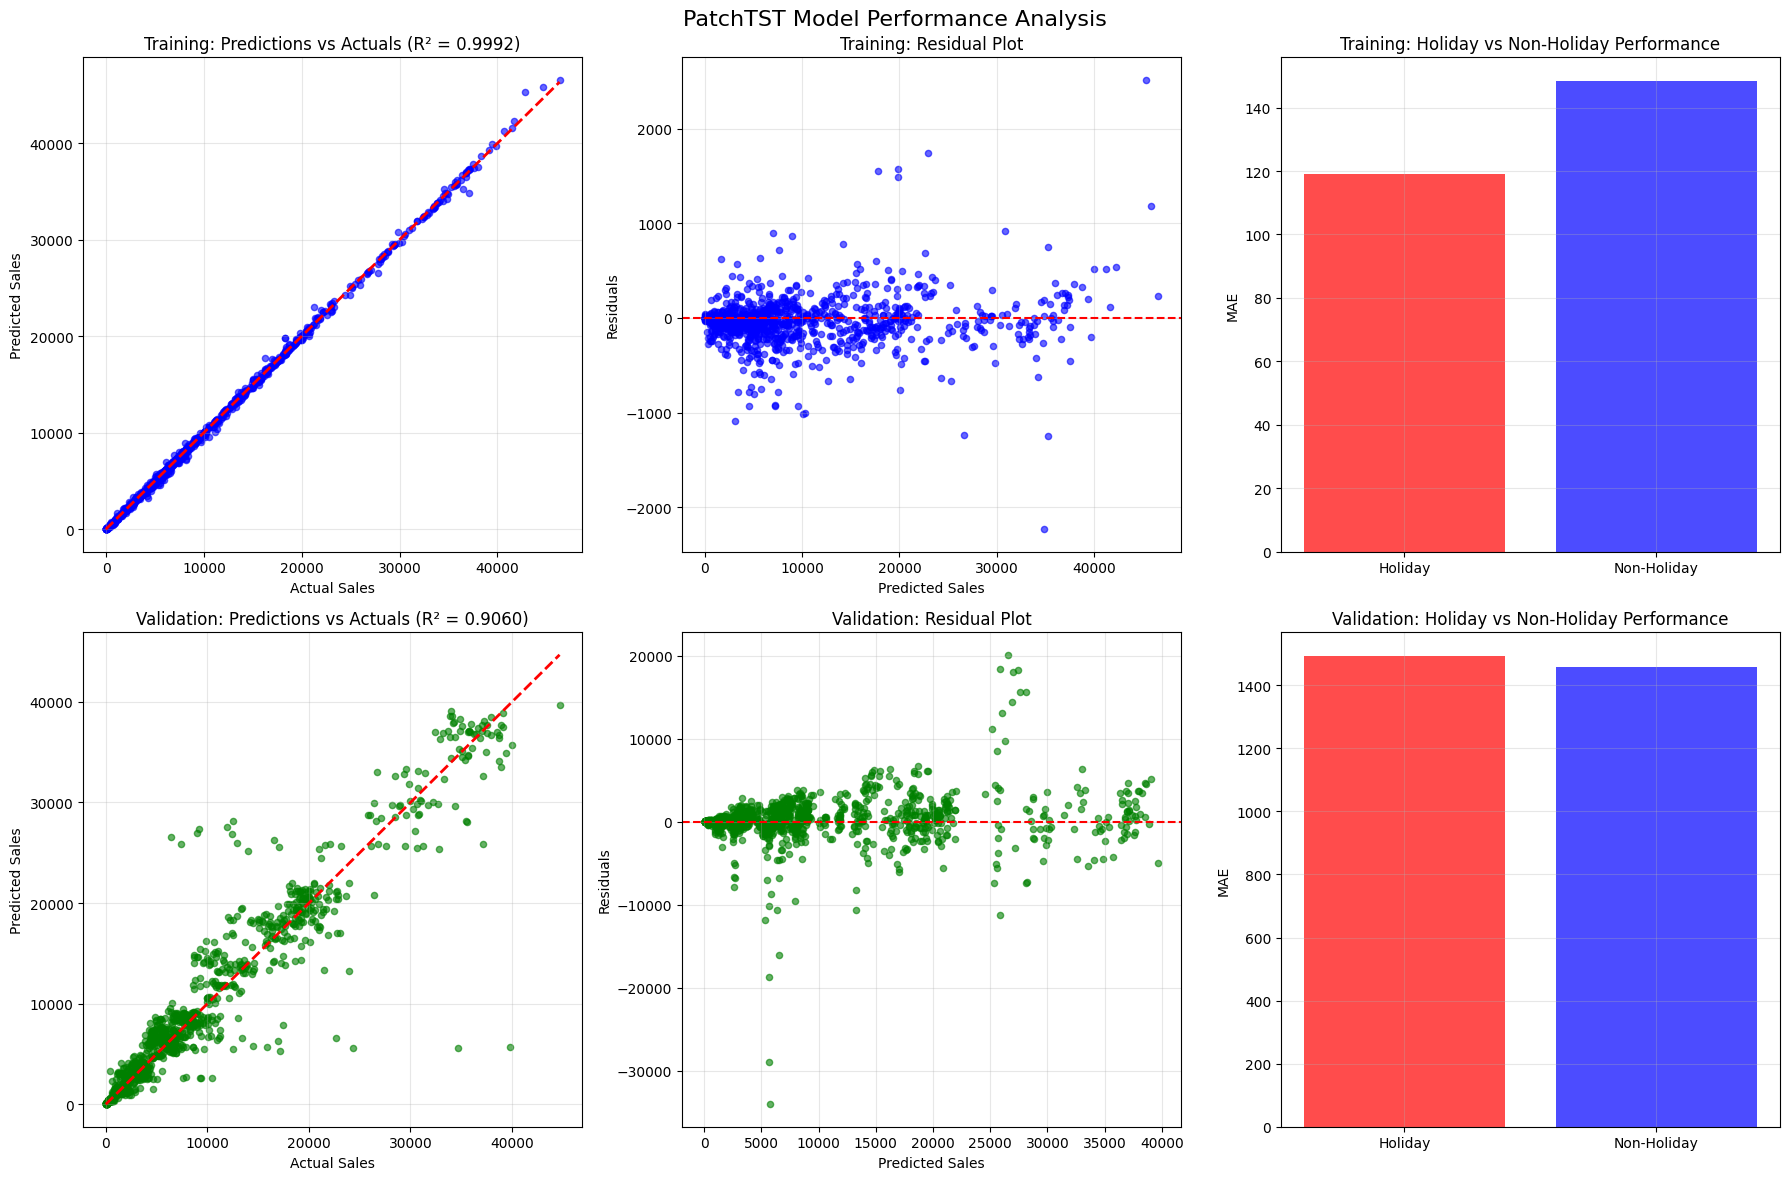

✅ Visualizations complete!

💾 Step 7: Saving model...
   ✅ Model saved: patchtst_model_20250711_131222.pth

🎉 Experiment complete!
   ⏱️ Total time: 357.19 seconds

📈 Training Results:
   🎯 Train WMAE: $139.22
   📊 Train MAE: $145.96
   📊 Train R²: 0.9992

📉 Validation Results:
   🎯 Val WMAE: $1,468.55
   📊 Val MAE: $1,460.37
   📊 Val R²: 0.9060


Train_Holiday_MAE,▁
Train_Holiday_Samples,▁
Train_Holiday_WMAE,▁
Train_MAE,▁
Train_Non_Holiday_MAE,▁
Train_Non_Holiday_Samples,▁
Train_Non_Holiday_WMAE,▁
Train_RMSE,▁
Train_R²,▁
Train_Total_Samples,▁
Train_WMAE,▁


In [22]:
if __name__ == "__main__":
    main()